In [ ]:
# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.

In [65]:
import os
import random

directory = 'data'
symbols = [f.replace('times', 'T') for f in os.listdir(directory)]
strings = [' '.join(''.join(random.choices(symbols, k=random.randint(3, 5))) for _ in range(2)) for _ in range(10)]

print(f"Symbols: {symbols}\nStrings: {strings}")

Symbols: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', 'T', 'w', 'X', 'y']
Strings: ['(1tX -X9X3', 'XX9 9T)21', '7+h 7ht,', '8+786 Th1', '680(- y9w', '481)- 5(9', '(43X (ttw,', '7T(X twy-h', '3,7h --87w', '740 )8y']


In [66]:
# Каждому набору поставить в соотвествие массив изображений соответствующих символов.

In [67]:
def get_symbol_images_map(directory, symbols):
    symbol_images = {}
    for symbol in symbols:
        folder = os.path.join(directory, symbol if symbol != 'times' else 'T')
        symbol_images[symbol] = [os.path.join(folder, img) for img in os.listdir(folder)]
    return symbol_images

In [68]:
def get_string_images_map(strings, symbol_images):
    string_images = {}
    for string in strings:
        images = [
            symbol_images[char][random.randint(0, len(symbol_images[char]) - 1)] if char != ' ' else 'space'
            for char in string
        ]
        string_images[string] = images
    return string_images

In [69]:
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

In [ ]:
from PIL import Image
def combine_images_with_spaces(images, min_scale=0.8, max_scale=0.9, max_offset=50, spacing=10, space_width=20):
    scaled_images = []
    
    for img_path in images:
        if img_path == 'space':
            space_img = Image.new('RGB', (space_width, 1), (255, 255, 255))
            scaled_images.append(space_img)
        else:
            img = Image.open(img_path)
            scale = random.uniform(min_scale, max_scale)
            img = img.resize((int(img.width * scale), int(img.height * scale)), Image.LANCZOS)
            scaled_images.append(img)
    
    total_width = sum(img.width for img in scaled_images) + spacing * (len(scaled_images) - 1)
    max_height = max(img.height for img in scaled_images) + max_offset
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for img in scaled_images:
        y_offset = random.randint(0, max_offset)
        combined_image.paste(img, (x_offset, y_offset))
        x_offset += img.width + spacing

    return combined_image

In [71]:
symbol_images = get_symbol_images_map(directory, symbols)
string_images = get_string_images_map(strings, symbol_images)

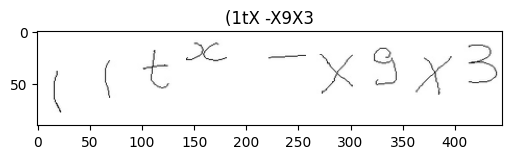

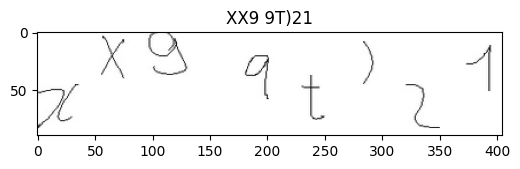

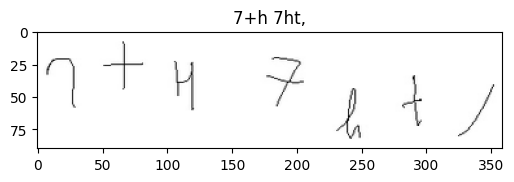

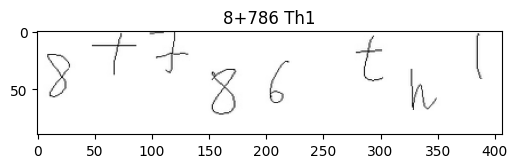

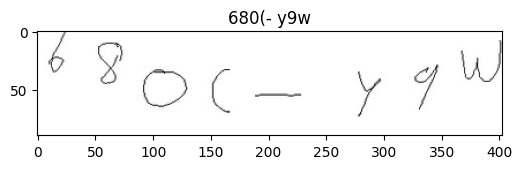

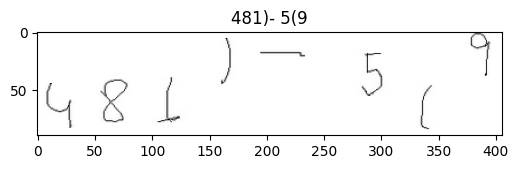

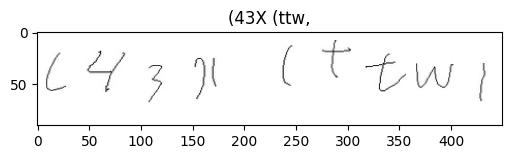

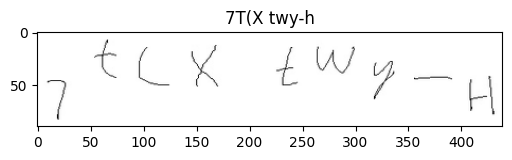

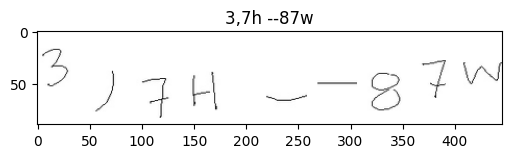

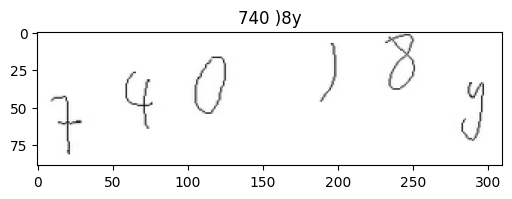

In [72]:
import numpy as np

output_directory = 'generated_images'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

generated_images_paths = {}

import matplotlib.pyplot as plt
for i, (string, images) in enumerate(string_images.items(), start=1):
    combined_image = combine_images_with_spaces(images)
    
    image_path = f'{output_directory}/{i}.png'
    combined_image.save(image_path)
    
    generated_images_paths[string] = image_path
    
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_image)
    plt.title(string)
    plt.show()

In [73]:
# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.

In [74]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_cv_image(image):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (28, 28)).flatten()
    
    return None
    
def prepare_data(data_dict):
    X = []
    y = []
    
    def process_label_images(label, img_paths):
        vectors = [get_vector(path) for path in img_paths]
        labels = [label] * len(vectors)
        return vectors, labels

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda item: process_label_images(*item), data_dict.items()))
        
    for vectors, labels in results:
        X.extend(vectors)
        y.extend(labels)
    
    return np.array(X), np.array(y)

In [75]:
# Разделяем данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
symbol_images = get_symbol_images_map(directory, symbols)
X, y = prepare_data(symbol_images)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [77]:
# Оптимизация параметра k для KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def find_optimal_k(X_train, y_train, k_range=(1, 10)):
    param_grid = {'n_neighbors': list(range(k_range[0], k_range[1] + 1))}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_['n_neighbors']

In [26]:
# Поиск оптимального k
optimal_k = find_optimal_k(X_train, y_train)
print(f"Optimal k = {optimal_k}")

Optimal k = 1


In [27]:
# Обучение классификатора с найденным оптимальным k
from sklearn.metrics import accuracy_score

knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy}")

Classification accuracy: 0.9759891707165523


In [29]:
# Сохранение модели для дальнейшего использования
import pickle

model_path = 'knn_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(knn_classifier, model_file)

In [62]:
def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]
    
    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]
    
    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return symbols

In [104]:
from difflib import SequenceMatcher
import editdistance

def calculate_cer(true_text, predicted_text):
    return editdistance.eval(true_text, predicted_text) / len(true_text) if len(true_text) > 0 else 0

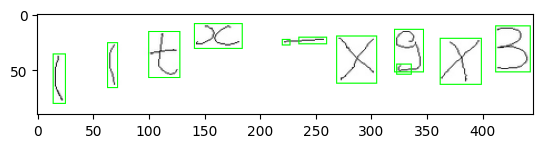

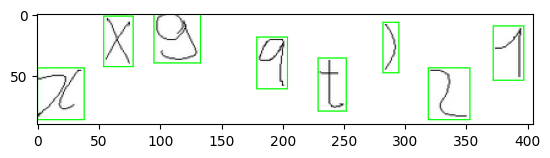

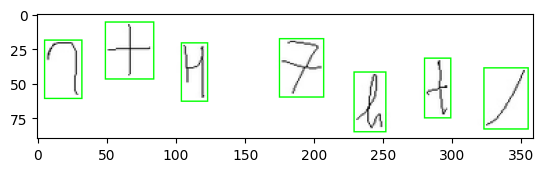

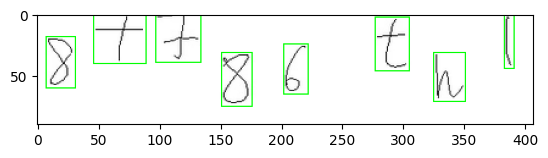

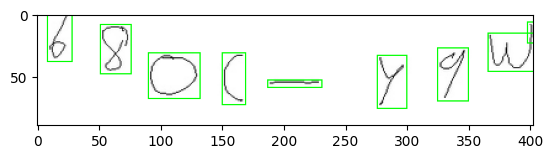

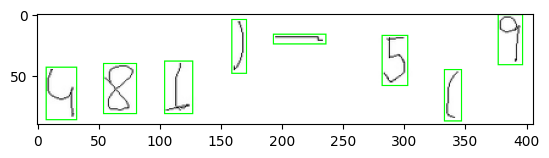

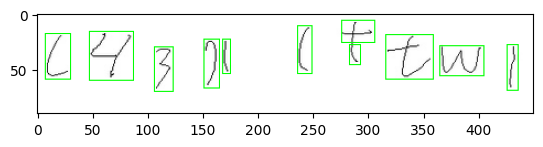

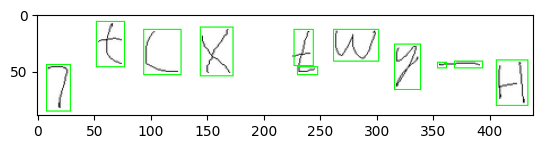

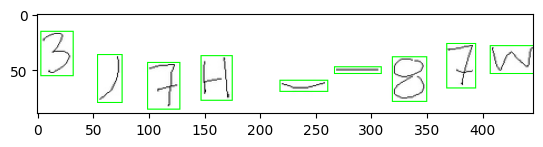

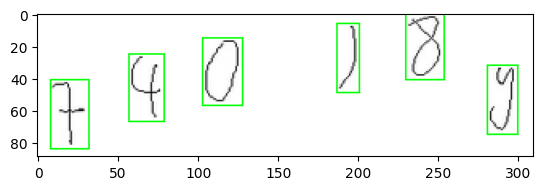

In [105]:
results = []

def restore_text_from_image(image_path, model, true_string, max_symbols_per_string=10):

    symbol_vectors = extract_symbols(image_path)
    
    predicted_symbols = model.predict(symbol_vectors)
    
    restored_text = ''.join(predicted_symbols)
    cer = calculate_cer(true_string, restored_text)
    results.append((true_string, predicted_symbols, cer))
    
    restored_text = ''.join(predicted_symbols)
    return restored_text, cer

with open(model_path, 'rb') as file:
    model = pickle.load(file)

restored_string = {}

for string, image_path in generated_images_paths.items():
    restored_text, cer = restore_text_from_image(image_path, model, string)
    
    if restored_text:
        restored_string[string] = restored_text

In [106]:
from pandas import DataFrame, concat
df_results = DataFrame(results, columns=['Исходная строка', 'Предсказанная строка', 'CER'])
df_results

,Исходная строка,Предсказанная строка,CER
0,(1tX -X9X3,"[(, 1, 2, X, 0, -, X, 3, -, X, -]",0.500000
1,XX9 9T)21,"[(, X, 1, 0, +, ), 2, 1]",0.555556
2,"7+h 7ht,","[-, +, 1, 2, ), t, ,]",0.625000
3,8+786 Th1,"[8, +, 7, 8, X, t, 1, 1]",0.444444
4,680(- y9w,"[-, X, 0, (, -, X, 9, -, 1]",0.666667
5,481)- 5(9,"[4, 8, -, ), -, X, -, 9]",0.444444
6,"(43X (ttw,","[-, 4, 4, X, 1, (, +, (, +, 1, ,]",0.700000
7,7T(X twy-h,"[1, +, -, X, 1, -, (, y, 1, ), h]",0.800000
8,"3,7h --87w","[+, ,, 7, h, 5, 0, ), -, 1]",0.700000
9,740 )8y,"[+, +, 0, 1, X, y]",0.714286


In [ ]:
# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.

In [107]:
def modify_text(text, delete_prob=0.1, insert_prob=0.1):
    modified_text = []
    for char in text:
        if random.random() > delete_prob:
            modified_text.append(char)
        
        if random.random() < insert_prob:
            modified_text.append(chr(random.randint(32, 126)))
    
    return ''.join(modified_text)

In [108]:
for idx, row in df_results.iterrows():
    original_text = row["Исходная строка"]
    predicted_text = row["Предсказанная строка"]
    
    modified_predicted_text = modify_text(predicted_text)
    
    cer = calculate_cer(original_text, modified_predicted_text)
    
    df_results.at[idx, "Предсказанная строка"] = modified_predicted_text
    df_results.at[idx, "CER"] = cer

df_results

,Исходная строка,Предсказанная строка,CER
0,(1tX -X9X3,(12X0-X3-X-,0.500000
1,XX9 9T)21,(X10+)21,0.555556
2,"7+h 7ht,","-),",0.875000
3,8+786 Th1,8+78(Xz11J,0.555556
4,680(- y9w,-#X0(-9[-1,0.777778
5,481)- 5(9,4Q8-)S-X9Z,0.777778
6,"(43X (ttw,","-44X1(`+(+1""",0.900000
7,7T(X twy-h,1+-X1-(]p1)wh,1.100000
8,"3,7h --87w","+,7h5)-1",0.600000
9,740 )8y,++0k1fXy,0.857143
